# Вводная информация

В этом проекте предполагается работа с датасетом из открытого источника.  
Потребуется разработать модель машинного обучения, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке.

В ходе работы над проектом будут решены следующие задачи:  
1) Исследование датасета  
2) Предобработка данных  
3) Обучение модели  
4) Подготовка предсказания на тестовой выборке  
5) Подготовка скриптов и библиотеки для обработки данных и предсказания на тестовой выборке  
6) Написание инструмента для тестирования  
7) Оформление документации  

Данные пациентов для предсказания риска сердечных приступов:  
1) id  - id  
2) Антропометрические параметры (вес, возраст, рост)  
3) Привычки (курение, качество сна и т.д)  
4) Давление  
5) Наличие хронических заболеваний  
6) Биохимия крови  
7) Таргет - высокий или низкий риск поражения сердца  


<b><i>Что имеем в таблице</i></b>  
<b>Высокая ценность для модели</b>:  
Age (возраст) – количество полных лет.  
Cholesterol (холестерин) – уровень общего холестерина в крови (ммоль/л или мг/дл).  
Heart rate (частота сердечных сокращений) – пульс в состоянии покоя (ударов в минуту).  
Diabetes (диабет) – наличие диагноза диабета (0 – нет, 1 – есть).  
Family History (наследственность) – наличие сердечно-сосудистых заболеваний у ближайших родственников (0/1).  
Smoking (курение) – факт курения (0 – не курит, 1 – курит).  
Obesity (ожирение) – наличие ожирения (0/1).  
Previous Heart Problems (анамнез сердечных проблем) – наличие ранее диагностированных сердечных заболеваний (0/1).  
Medication Use (приём лекарств) – факт приёма сердечно-сосудистых или сопутствующих препаратов (0/1).  
BMI (индекс массы тела) – показатель веса относительно роста.  
Triglycerides (триглицериды) – уровень триглицеридов в крови.  
Blood sugar (уровень сахара в крови) – показатель глюкозы (ммоль/л или мг/дл).  
Systolic blood pressure (систолическое давление) – верхнее значение артериального давления (мм рт. ст.).  
Diastolic blood pressure (диастолическое давление) – нижнее значение артериального давления (мм рт. ст.).  

<b>Средняя ценность для модели</b>:
Alcohol Consumption (употребление алкоголя) – частота или факт употребления алкоголя (0/1 или категориально).  
Exercise Hours Per Week (часы тренировок в неделю) – среднее количество часов физической активности за неделю.  
Diet (диета) – качество или тип питания (может быть категориально: сбалансированная/несбалансированная и т.д.).  
Stress Level (уровень стресса) – субъективная или измеренная оценка уровня стресса (шкала).  
Sedentary Hours Per Day (сидячие часы в день) – количество часов в день, проводимых в сидячем положении.  
Physical Activity Days Per Week (дни активности в неделю) – количество дней с умеренной или высокой физической активностью.  
Sleep Hours Per Day (часы сна в день) – среднее количество часов сна за сутки.  
Gender (пол) – 0 – женский, 1 – мужской (или наоборот).  

<b>Потенциально бесполезные признаки</b>:  
Income (доход) – уровень дохода, будет корелировать с образом жизни.  

<b>Признаки указывающие УЖЕ на проблемы с сердцем и могу дать утечку данных</b>:  
CK-MB – уровень изофермента креатинфосфокиназы MB, маркера повреждения сердца.  
Troponin (тропонин) – уровень тропонина, маркер повреждения миокарда.  

<b>Технические признаки</b>:  
id – идентификатор записи.  
Heart Attack Risk (Binary) (риск инфаркта, бинарно) – целевой признак: 0 – нет риска, 1 – есть риск.  

# Ипорты

In [1]:
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Классы и функции проекта

In [2]:
# Чистит названия столбцов, преобразует к общепринятому виду. В строках удаляет лишние пробелы, если есть
class ColumnNameProcessor:
    @staticmethod
    def process_spaces(s):
        """Удаляет лишние пробелы внутри строки и по краям."""
        if isinstance(s, str):
            s = s.strip()
            s = ' '.join(s.split())
        return s

    @staticmethod
    def replace_spaces(s):
        """Заменяет пробелы на нижнее подчеркивание в строках."""
        if isinstance(s, str):
            s = s.strip()
            s = '_'.join(s.split())
        return s

    def clean_dataframe(self, df):
        """
        Приводит названия колонок к нижнему регистру,
        убирает пробелы, заменяет их на '_',
        а также чистит строки внутри DataFrame.
        """
        # Названия колонок
        df.columns = [self.replace_spaces(self.process_spaces(col)).lower() for col in df.columns]
        
        # Чистка строковых значений
        df = df.map(self.process_spaces)
        df = df.map(lambda x: self.process_spaces(x).lower() if isinstance(x, str) else x)
        
        return df
    
def plot_combined(data, col=None, target=None, col_type=None, legend_loc='best'):
    """
    Строит графики для числовых столбцов в DataFrame, автоматически определяя их типы (дискретные или непрерывные).

    :param data: DataFrame, содержащий данные для визуализации.
    :param col: Список столбцов для построения графиков. Если None, будут использованы все числовые столбцы.
    :param target: Столбец, по которому будет производиться разделение (для hue в графиках).
    :param col_type: Словарь, определяющий типы столбцов ('col' для непрерывных и 'dis' для дискретных).
                     Если None, типы будут определены автоматически.
    :param legend_loc: Положение легенды для графиков (по умолчанию 'best').
    :return: None. Графики отображаются с помощью plt.show().
    """
    
    # Определяем числовые столбцы
    if col is None:
        numerical_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    else:
        numerical_columns = col

    # Если col_type не указан, определяем типы автоматически
    if col_type is None:
        col_type = {}
        for col in numerical_columns:
            unique_count = data[col].nunique()
            if unique_count > 20:
                col_type[col] = 'col'  # Непрерывные данные
            else:
                col_type[col] = 'dis'  # Дискретные данные

    total_plots = len(numerical_columns) * 2
    ncols = 2
    nrows = (total_plots + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axs = axs.flatten()

    index = 0

    for col in numerical_columns:
        # Определяем тип графика
        plot_type = col_type.get(col)
        if plot_type is None:
            raise ValueError(f"Тип для столбца '{col}' не указан в col_type.")

        # Гистограмма или countplot
        if index < len(axs):
            if plot_type == 'col':
                if target is not None:
                    sns.histplot(data, x=col, hue=target, bins=20, kde=True, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.histplot(data[col].dropna(), bins=20, kde=True, ax=axs[index])
                axs[index].set_title(f'Гистограмма: {col}')
                axs[index].tick_params(axis='x', rotation=90)  # Вертикальные метки

            elif plot_type == 'dis':
                if target is not None:
                    sns.countplot(data=data, x=col, hue=target, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.countplot(data=data, x=col, ax=axs[index])
                axs[index].set_title(f'Countplot: {col}')
                axs[index].tick_params(axis='x', rotation=90)  # Вертикальные метки

            index += 1

        # Боксплот
        if index < len(axs):
            sns.boxplot(x=data[col], ax=axs[index])
            axs[index].set_title(f'Боксплот: {col}')
            index += 1

    # Отключаем оставшиеся оси
    for j in range(index, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
def plot_categorical_columns(data, col=None, target=None):
    """
    Функция для визуализации категориальных данных с возможностью группировки по целевому столбцу.
    
    :param data: DataFrame с категориальными данными
    :param col: Название столбца для визуализации (по умолчанию None — визуализируются все категориальные столбцы)
    :param target: Название столбца для группировки данных (по умолчанию None — без группировки)
    :return: None — функция отображает графики
    """
    categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
    
    if col is not None and col in categorical_columns:
        categorical_columns = [col]
    elif col is not None:
        print(f"Столбец '{col}' не найден в данных.")
        return

    n = len(categorical_columns)
    ncols = 2
    nrows = (n * 2 + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))
    axs = axs.flatten()

    index = 0
    colors = plt.cm.tab10.colors

    for col in categorical_columns:
        unique_values = data[col].value_counts().index
        color_map = {value: colors[i] for i, value in enumerate(unique_values)}

        # Визуализация круговой диаграммы
        grouped_data = data[col].value_counts()
        axs[index].pie(grouped_data, labels=grouped_data.index, autopct='%1.1f%%', startangle=90, colors=[color_map[val] for val in grouped_data.index])
        axs[index].set_title(f'{col} (общая)')
        axs[index].set_ylabel('')
        index += 1

        # Визуализация гистограммы
        if target is not None and target in data.columns:
            # Создаем MultiIndex для unstack
            grouped_data = data.groupby([target, col]).size().unstack(fill_value=0)
            grouped_data.plot(kind='bar', ax=axs[index], color=[color_map[val] for val in grouped_data.columns])
        else:
            data[col].value_counts().plot(kind='bar', ax=axs[index], color=[color_map[val] for val in data[col].value_counts().index])

        axs[index].set_title(f'{col} (гистограмма)')
        axs[index].set_ylabel('Частота')
        index += 1

    for j in range(index, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
# пропуски
def missing_data(data):
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data > 0]
    display(missing_data)
    
def calc_target_correlations(df, target_col: str = None, drop_cols: list = None):
    """
    Считает корреляции признаков с таргетом, строит heatmap и рассчитывает VIF.
    Результаты выводятся прямо в Jupyter.
    """
    if drop_cols is None:
        drop_cols = []
    
    df_tmp = df.copy()

    # Преобразуем категориальные в числовые
    cat_cols = df_tmp.select_dtypes(include=["object", "category"]).columns
    for c in cat_cols:
        df_tmp[c] = df_tmp[c].astype("category").cat.codes

    # Числовые колонки
    numeric_cols = df_tmp.select_dtypes(exclude=["object", "category"]).columns.tolist()
    if target_col not in numeric_cols:
        raise ValueError(f"target_col '{target_col}' должен быть числовым")

    # Корреляции с target
    corr_df = (
        df_tmp[numeric_cols]
        .corr()[target_col]
        .drop(target_col)
        .sort_values(key=np.abs, ascending=False)
    )
    display("=== Корреляция с таргетом ===")
    display(corr_df)

    # Heatmap
    heatmap_cols = [col for col in numeric_cols if col not in drop_cols or col == target_col]
    corr_matrix = df_tmp[heatmap_cols].corr()

    plt.figure(figsize=(12, 10))
    plt.imshow(corr_matrix, interpolation="nearest", cmap="coolwarm", aspect="auto")
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=8)
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=8)
    plt.colorbar()
    plt.title("Correlation Heatmap (включая target)")

    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            value = corr_matrix.iloc[i, j]
            plt.text(j, i, f"{value:.2f}", ha="center", va="center", fontsize=6, color="black")

    plt.tight_layout()
    plt.show()

    # VIF
    vif_cols = [col for col in numeric_cols if col != target_col and col not in drop_cols]
    X_vif = df_tmp[vif_cols].copy()
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_vif), columns=vif_cols)

    vif_data = pd.DataFrame()
    vif_data["feature"] = vif_cols
    vif_data["VIF"] = [
        variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])
    ]
    vif_data = vif_data.sort_values("VIF", ascending=False)

    display("\n=== VIF ===")
    display(vif_data)
    

# Исследование датасета

## Подгружаем базы

In [3]:
train_data = pd.read_csv('../src/data/raw/heart_train.csv')
test_data = pd.read_csv('../src/data/raw/heart_test.csv')

## Общая статистика

In [4]:
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

None

In [5]:
cols_by_dtype = {dtype: train_data.select_dtypes(include=[dtype]).columns.tolist()
                 for dtype in train_data.dtypes.unique()}

for dtype, cols in cols_by_dtype.items():
    print(dtype, ":", cols)

int64 : ['Unnamed: 0', 'Diet', 'id']
float64 : ['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk (Binary)', 'Blood sugar', 'CK-MB', 'Troponin', 'Systolic blood pressure', 'Diastolic blood pressure']
object : ['Gender']


In [6]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,8685.0,4342.000000,2507.287877,0.0,2171.000000,4342.000000,6513.000000,8684.0
Age,8685.0,0.449958,0.231174,0.0,0.258427,0.460674,0.640449,1.0
Cholesterol,8685.0,0.501070,0.284716,0.0,0.267857,0.499780,0.746429,1.0
Heart rate,8685.0,0.050658,0.023453,0.0,0.034830,0.050412,0.065995,1.0
Diabetes,8442.0,0.652097,0.476333,0.0,0.000000,1.000000,1.000000,1.0
Family History,8442.0,0.489576,0.499921,0.0,0.000000,0.000000,1.000000,1.0
Smoking,8442.0,0.902867,0.296157,0.0,1.000000,1.000000,1.000000,1.0
Obesity,8442.0,0.498342,0.500027,0.0,0.000000,0.000000,1.000000,1.0
Alcohol Consumption,8442.0,0.601990,0.489517,0.0,0.000000,1.000000,1.000000,1.0
Exercise Hours Per Week,8685.0,0.503378,0.284810,0.0,0.263286,0.502110,0.748709,1.0


## Пропуски

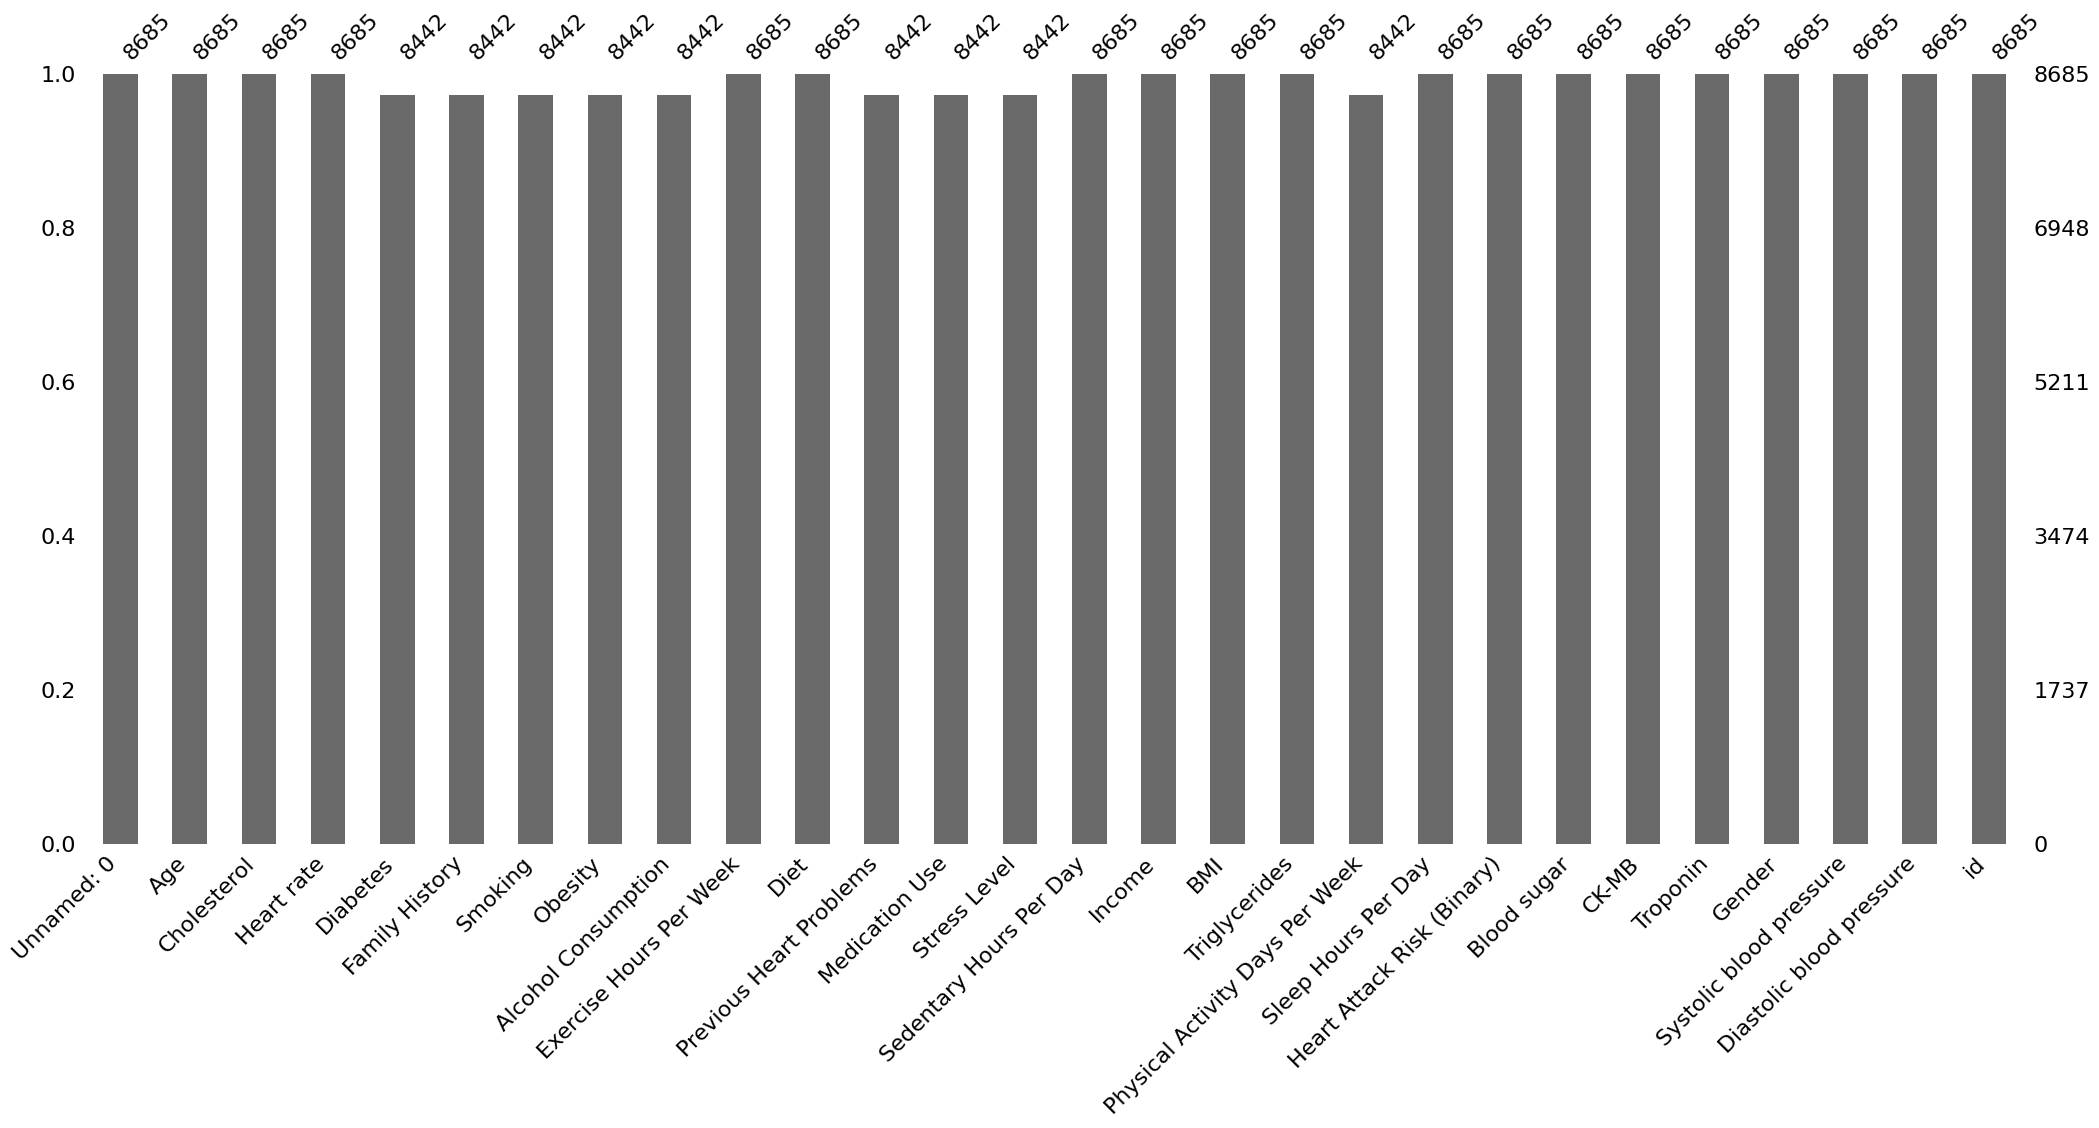

Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Physical Activity Days Per Week    243
dtype: int64

In [7]:
if train_data.isnull().sum().sum() > 0:
    msno.bar(train_data)
    plt.show()
    
    missing_data(train_data)

пропуски в части важных для модели признаков и части в бесполезных.

## Распределение числовых данных

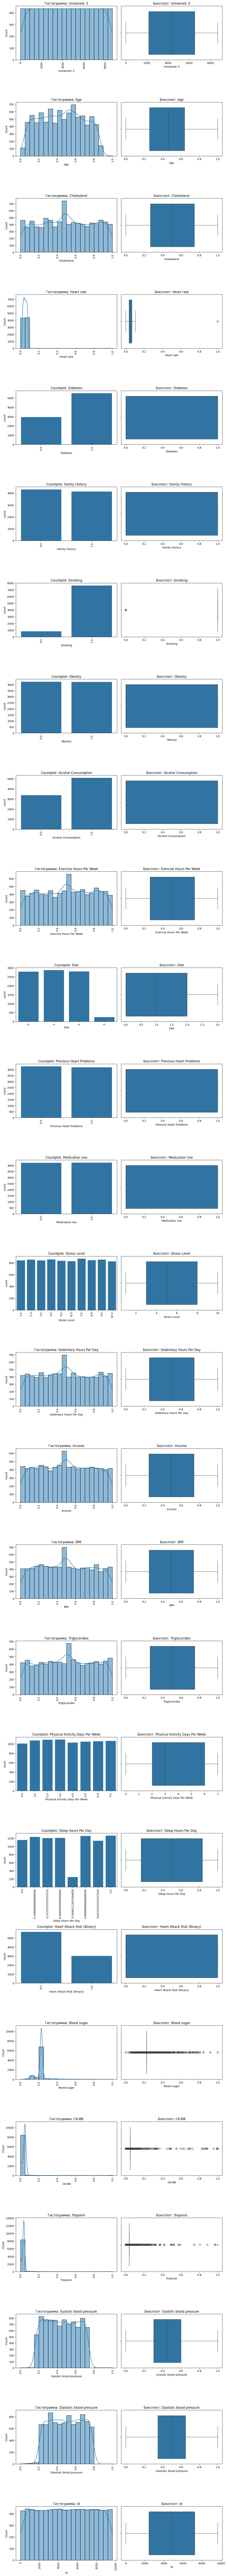

In [8]:
plot_combined(train_data, col=None, target=None, col_type=None, legend_loc='best')

CK-MB, Troponin - ненормальное распределение + мы их относим в опасным признакам и не будем использовать в обучении  
К остальным вопросов нет

## Распределение категориальных данных

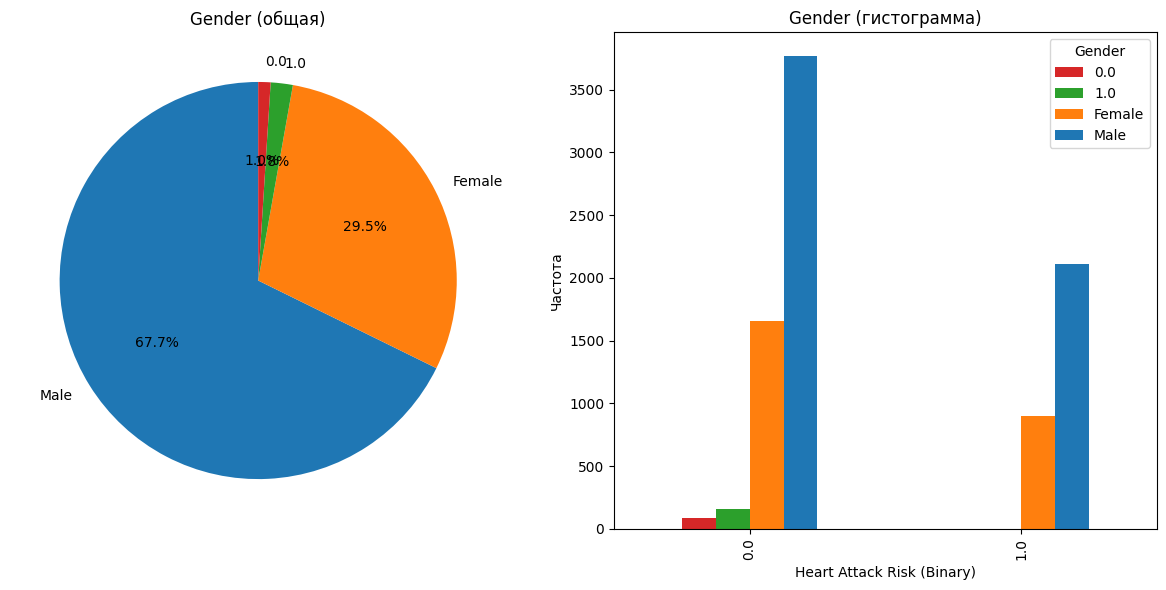

In [9]:
plot_categorical_columns(train_data, col=None, target="Heart Attack Risk (Binary)")

1 к 3, лучше бы было, если женщин/мужчин было бы поровну

In [10]:
train_data["Gender"].value_counts()

Gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

можно будет попробовать выровнять число мужчин/женщин, по идее даст более качественную модель, посмотрим по ходу дела...  
и учитывая равное число пропусков и часть гендера в виде 0/1 можно смело заявлять, чтобы было кривое объединение 2х баз данных, но, к сожалению, оно не дало пользы, т.к. мы имеем пропуски и не знаем какой гендер под 0/1, а использовать это наугад смертельно непозволительно для нас

In [11]:
train_data.sample(10)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
236,236,0.303371,0.785714,0.059578,0.0,0.0,1.0,1.0,1.0,0.061856,...,2.0,0.666667,1.0,0.227018,0.048229,0.036512,Female,0.303226,0.686047,8791
719,719,0.258427,0.403571,0.030247,0.0,1.0,1.0,0.0,1.0,0.321062,...,5.0,0.666667,0.0,0.227018,0.048229,0.036512,Male,0.225806,0.709302,334
5403,5403,0.168539,0.857143,0.019248,1.0,0.0,1.0,0.0,1.0,0.672934,...,0.0,0.166667,1.0,0.227018,0.048229,0.036512,Male,0.258065,0.348837,7917
4304,4304,0.325843,0.514286,0.082493,1.0,0.0,1.0,0.0,1.0,0.812726,...,2.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.367742,0.348837,4785
6021,6021,0.539326,0.900000,0.036664,1.0,0.0,1.0,1.0,0.0,0.454688,...,6.0,0.500000,1.0,0.363636,0.030129,0.000388,Male,0.729032,0.639535,4256
5920,5920,0.303371,0.675000,0.074244,1.0,0.0,1.0,1.0,1.0,0.376454,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.690323,0.209302,9113
4558,4558,0.089888,0.160714,0.028414,0.0,1.0,0.0,0.0,1.0,0.424489,...,7.0,0.000000,0.0,0.227018,0.048229,0.036512,Female,0.206452,0.662791,3109
6341,6341,0.337079,0.557143,0.049496,1.0,0.0,1.0,1.0,0.0,0.928160,...,3.0,0.166667,1.0,0.090909,0.202814,0.004175,Male,0.535484,0.406977,6272
5258,5258,0.662921,0.357143,0.043996,0.0,0.0,1.0,1.0,1.0,0.749312,...,6.0,0.000000,1.0,0.116601,0.032164,0.001068,Female,0.329032,0.372093,785
403,403,0.303371,0.192857,0.027498,1.0,0.0,1.0,1.0,0.0,0.316182,...,5.0,0.333333,0.0,0.227018,0.048229,0.036512,Female,0.451613,0.534884,8349


## Выводы/план предобработки

Судя по примерам в выводе - данные уже почти все нормализованны.  
Что надо сделать:  
1) Удалить непонятный столбец, дублирующий номер строки;  
2) Названия столбцов привести к строчным буквам, пробелы заменить на нижнее подчеркивание;  
3) Удалить строки с пропусками/непонятными данными - сердце это не шутки, мы не можем себе позволить заполнять пропуски случайными данными;  
4) Закодировать "редкие" признаки в OneHotEncoder - diabetes, family_history, smoking, obesity, alcohol_consumption, diet, previous_heart_problems, medication_use, gender, предварительно переведем все в int;  
5) Обобщить признаки, сделать "lifestyle_bad" (образ жизни негативный), где перемножим Smoking (курение), Obesity (ожирение), Alcohol Consumption (употребление алкоголя), Sedentary Hours Per Day (сидячие часы в день);  
6) Обобщить признаки, сделать "lifestyle_good" (образ жизни спортивный), где перемножим Exercise Hours Per Week (часы тренировок в неделю), Diet (диета), Physical Activity Days Per Week (дни активности в неделю);  
7) Удалить дубликаты; 

# Предобработка данных

Вначале посмотрел/сделал по отдельности, потом сделал с сохранением препроцессора для последующего использования в проде

In [12]:
# сразу сделаем id индексом
train_data = train_data.set_index('id', drop=True)

In [13]:
# удаляем столбец
train_data = train_data.drop(columns=['Unnamed: 0'])

In [14]:
# приводим названия к общепринятому виду
train_data = ColumnNameProcessor().clean_dataframe(train_data)

In [15]:
# в начале удаляем строки где есть хотя бы 1 пропуск
train_data = train_data.dropna()

In [ ]:
# проверим, что в гендерах
train_data["gender"].unique()
# почистим все что не гендер
train_data = train_data[train_data["gender"].isin(["male", "female"])]

array(['male', 'female'], dtype=object)

In [17]:
# составим список из не нужных признаков
drop_cols = ['income', 'ck-mb', 'troponin']

In [18]:
# удалим их
train_data = train_data.drop(drop_cols, axis=1)

In [19]:
# закодируем
ohe_cols = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'diet', 'previous_heart_problems', 'medication_use', 'gender']

In [20]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded = encoder.fit_transform(train_data[ohe_cols])
encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(ohe_cols),
    index=train_data.index
)
train_data = pd.concat([train_data.drop(columns=ohe_cols), encoded_df], axis=1)

In [21]:
# можно теперь чистить дубликаты
train_data = train_data.drop_duplicates()

'=== Корреляция с таргетом ==='

systolic_blood_pressure            0.025892
diet_1                             0.019076
cholesterol                        0.018939
sleep_hours_per_day               -0.018856
diabetes_1.0                       0.016745
alcohol_consumption_1.0           -0.014805
obesity_1.0                       -0.014472
physical_activity_days_per_week   -0.012152
triglycerides                      0.011856
exercise_hours_per_week            0.009917
gender_male                        0.007362
age                                0.007274
diet_2                            -0.007133
bmi                               -0.006841
stress_level                      -0.005868
diastolic_blood_pressure          -0.005619
smoking_1.0                       -0.005435
blood_sugar                       -0.004285
family_history_1.0                 0.002883
previous_heart_problems_1.0        0.001336
heart_rate                        -0.001325
sedentary_hours_per_day            0.001021
medication_use_1.0              

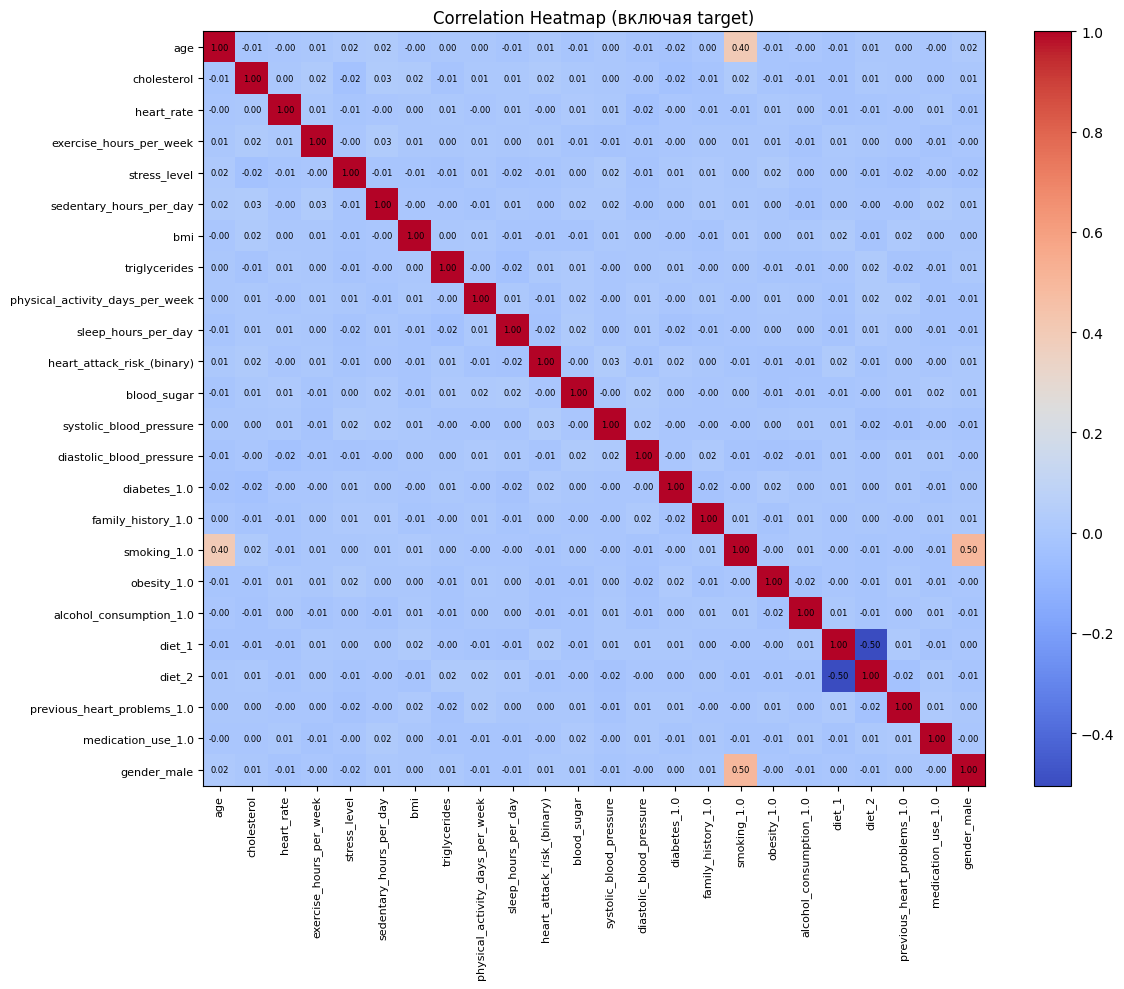

'\n=== VIF ==='

,feature,VIF
15,smoking_1.0,1.661954
22,gender_male,1.401826
19,diet_2,1.344163
18,diet_1,1.343519
0,age,1.250255
1,cholesterol,1.004523
4,stress_level,1.003811
5,sedentary_hours_per_day,1.003572
12,diastolic_blood_pressure,1.003303
20,previous_heart_problems_1.0,1.002866


In [22]:
# и посмотреть на зависимости признаков
corr = calc_target_correlations(train_data, target_col="heart_attack_risk_(binary)", )

Сильной кореляции между таргетом и признаками не наблюдается  
В целом, по базе, есть явная зависимость - взрослые мужчины курят  
Мультиколлинеарность также не наблюдается